In [21]:
import numpy as np
import pandas as pd 


from skimage import io

import matplotlib.pyplot as plt

import gabor_filters
from  gabor_filters import gabor_filter
from  gabor_filters import gabor_filter_response

from gabor_filters.gabor_filter import GaborFilter as gb
from gabor_filters.gabor_filter import GaborFilterBank as gbb

from gabor_filters.gabor_filter_response import GaborFilterResponse as gbfr
from gabor_filters.gabor_filter_response import GaborFilteredResponseBank as gbfrb

import importlib
importlib.reload(gabor_filters)
# importlib.reload(gabor_filters.gabor_filter_response)

from gabor_filters.gabor_filter import GaborFilter as gb
from gabor_filters.gabor_filter import GaborFilterBank as gbb


from gabor_filters.gabor_filter_response import GaborFilterResponse as gbfr
from gabor_filters.gabor_filter_response import GaborFilteredResponseBank as gbfrb

In [1]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean

from scipy import ndimage as ndi
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from skimage import exposure

# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

from platform import python_version

print(python_version())

print(skimage.__version__)

from sklearn.preprocessing import Normalizer
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

3.8.16
0.19.2


In [ ]:
def extract_hog_from_filepath(filepath):
    # read image from its path
    img = io.imread(filepath, as_gray=True)
    
    # resize the image for obtaining the same length of HOG feature 
    img_r = (resize(img,(256,256))*255).astype(np.uint8)
    
    # extract hog feature
    hog_feature = hog(img_r, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=False, feature_vector=True)
    
    #normalization
    # hog_feature=hog_feature/np.linalg.norm(hog_feature)
    
    return hog_feature

def extract_hog(dfDataset):
        
    HOG_features = Parallel(n_jobs=-5)(
                    delayed(extract_hog_from_filepath)(filepath) for filepath in tqdm(dfDataset['filenames'], position=1, desc='Extract HOG')
                )
    
    HOG_list=np.vstack(HOG_features)
    
    return HOG_list

## 4.2. main()

### 4.2.1. For fold 1
#### 1. Read path of fold 1 file

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

#### 2. Extracting HOG feature for the training set

In [ ]:
HOG_list = extract_hog(dfFoldTraining_1)

Extract HOG:   0%|          | 0/44099 [00:00<?, ?it/s]

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(HOG_list)

In [ ]:
# Standard deviation normalization
HOG_list_std = train_std_norm.transform(HOG_list)

In [ ]:
display(HOG_list_std)

array([[-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106],
       ...,
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106],
       [-0.05010858, -0.03541166, -0.04601461, ..., -0.07276438,
        -0.08904395, -0.07078106]])

In [ ]:
print('Total HOG features:',(HOG_list_std.shape))

Total HOG features: (44099, 2048)


#### 3. PCA analysis on the training set

In [ ]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

Text(0.5, 1.0, 'PCA analysis on HOG features of training set')

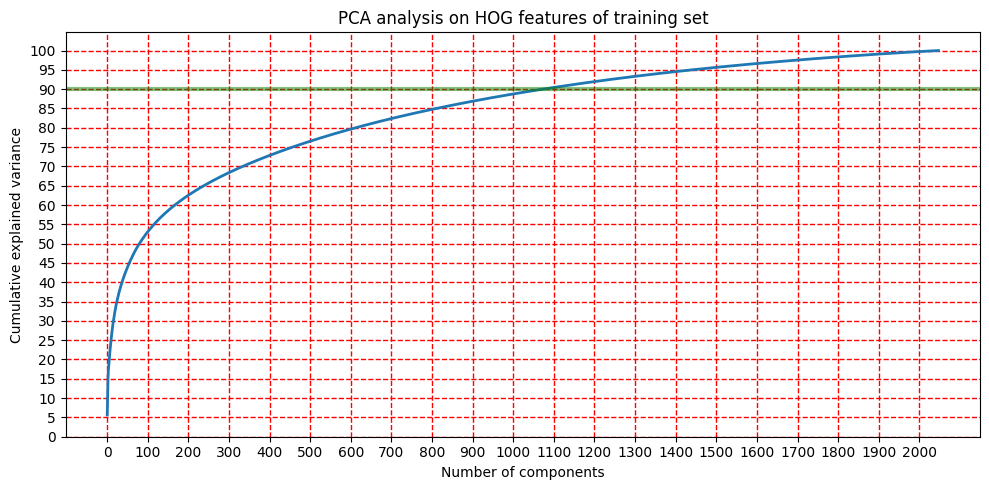

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

90.44853073965696

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

##### 3.2. Kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7


Text(0.5, 1.0, 'Scree Plot of PCA: Component Eigenvalues')

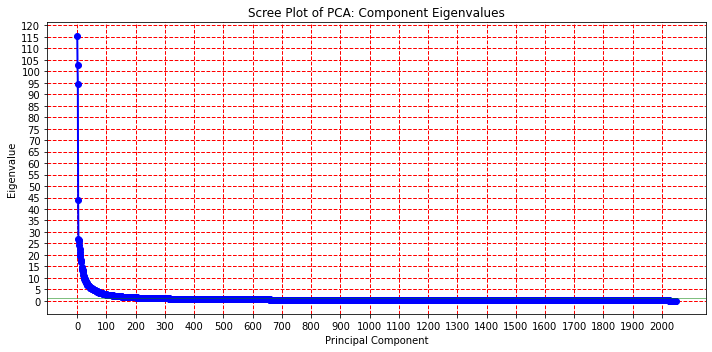

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(pca_HOG_std.explained_variance_, 'bo-', linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_yticks(np.arange(0,125,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='g', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')

In [ ]:
print('\nEigenvalues \n%s' %pca_HOG_std.explained_variance_)
print('Eigenvectors \n%s' %pca_HOG_std.components_)


Eigenvalues 
[1.15568612e+02 1.02669002e+02 9.46843646e+01 ... 9.83031116e-02
 9.43206197e-02 9.08247098e-02]
Eigenvectors 
[[ 0.01395531  0.00990388  0.01375403 ...  0.01237111  0.01375091
   0.01293913]
 [ 0.01194358  0.00841177  0.0112819  ...  0.01011539  0.01155574
   0.01031938]
 [ 0.00438814  0.00259772  0.00384605 ...  0.0035082   0.00417374
   0.00321487]
 ...
 [-0.11619066 -0.03793043  0.06569485 ... -0.01453993  0.06216408
   0.052127  ]
 [ 0.05078577  0.01776065 -0.09553286 ... -0.02083596  0.0406094
   0.02194985]
 [ 0.02113276 -0.00250593 -0.00594427 ... -0.01159366 -0.05829523
   0.01565881]]


In [ ]:
# kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7
a = pca_HOG_std.explained_variance_ >= 1.0

In [ ]:
a.sum()

309

<b> Only 309 components are significant and should be kept </b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

Original shape:    (44099, 2048)
Transformed shape: (44099, 1100)


In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0001-aggregates.png,0.917148,1.447246,0.206029,-1.107510,-1.734309,0.399973,0.329698,-0.708391,-0.284369,...,0.511516,1.532829,-0.091285,1.621535,-0.197880,0.682659,-0.838745,-0.156916,1.951763,-0.464003
1,0002.png,0.370505,-0.948531,0.756832,-0.493438,1.041628,-1.255949,-0.119693,-1.534237,-0.714659,...,-0.079446,-0.215757,1.081805,-0.632592,-1.280335,0.687809,-0.206522,1.736197,-0.415600,0.495210
2,0003-aggregates.png,2.865255,1.593701,0.678115,1.457410,-0.285363,-2.661964,-0.595322,1.991623,-1.164248,...,1.624138,1.999911,-0.900000,0.503939,-2.237205,-1.134731,0.243765,0.064901,0.600189,-1.111427
3,0004-aggregates.png,-1.317980,1.106058,-0.475207,0.014288,-0.773317,1.132120,0.918911,-1.054879,-1.039779,...,-0.454460,0.244967,-0.360653,1.493211,0.256294,-0.670891,-0.415434,-0.104941,0.209982,0.116195
4,0004.png,0.805215,-0.247367,1.353335,1.581153,-1.279883,-0.339334,-0.500247,-1.551780,-1.650041,...,-1.769747,0.593067,0.236974,-2.268845,1.587752,1.290187,-0.017582,0.530560,1.899955,-0.968483


(44099, 1101)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

Extract HOG:   0%|          | 0/14700 [00:00<?, ?it/s]

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

Original shape:    (14700, 2048)
Transformed shape: (14700, 1100)


In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0002-aggregates.png,-0.005962,0.047701,1.075164,-0.732217,-1.554549,0.148789,0.036890,0.857929,0.348601,...,1.376050,1.263499,0.995447,0.685557,-0.099480,-0.603319,-0.834841,1.428551,1.778422,1.221029
1,0006-aggregates.png,0.301887,-0.205501,0.333048,-0.741293,-0.972635,-0.357926,1.407182,-1.916246,0.145617,...,-0.441662,0.431345,1.046982,-0.620637,0.403026,-0.219844,-0.271041,-0.115279,-1.132150,0.786428
2,001-aggregates-jo_700_05.png,2.366545,0.749287,0.652475,-1.861808,-0.702044,-0.365452,0.328857,0.476454,0.367040,...,0.731662,3.773888,-0.604871,-0.923889,0.416154,-1.340859,0.559198,-0.620273,0.453902,-0.172933
3,0010-aggregates.png,-0.160033,0.347112,-0.668117,-0.461242,-0.508690,1.609127,-0.454135,-1.161684,-0.853908,...,0.444387,0.432414,-0.665007,-0.123202,-0.987345,-0.099243,-1.443244,1.550003,0.090061,0.305470
4,0011.png,0.012900,-0.917647,-1.639604,0.979652,-0.571192,0.432666,0.224566,2.290114,0.181760,...,0.061558,-0.936495,0.084808,1.413953,-0.674965,-1.838460,0.212193,-0.265324,-0.616324,0.788030


(14700, 1101)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

Extract HOG:   0%|          | 0/6907 [00:00<?, ?it/s]

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

Original shape:    (6907, 2048)
Transformed shape: (6907, 1100)


In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_1.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0007-aggregates_002.png,-0.083999,0.285228,1.056967,-1.102574,-0.732811,0.704804,-0.032445,-0.302684,0.461219,...,-1.192074,0.790377,0.517393,-0.096931,-0.706280,0.966497,0.393886,-0.692417,-0.349045,-0.716345
1,0009-aggregates_001.png,1.107838,-1.258026,-0.785372,0.486535,0.258588,2.908086,0.427533,0.276018,-0.867448,...,0.551549,-1.546961,-0.160959,0.598653,0.770346,0.262718,0.607093,-0.903584,0.244614,-1.806546
2,0012-aggregates_002.png,-0.226048,-0.929947,0.827838,0.395767,-0.144847,-0.650738,-0.817048,-0.418973,-0.809150,...,-1.091932,0.213372,-0.217287,2.521319,0.468563,-0.362330,0.147278,-1.238254,0.744157,0.388285
3,002-aggregates_001.png,0.743325,1.043750,-1.172682,-0.980800,0.279429,-1.244421,0.303815,0.206895,0.588795,...,-1.276829,1.945097,1.104895,0.495033,0.850021,-0.071929,-0.591222,2.768175,1.524619,2.143985
4,002-aggregates_007.png,1.662327,-0.054698,1.029701,0.370805,2.140615,-0.932924,1.840033,-1.019394,-2.440199,...,0.126361,-0.630941,0.162539,-0.159855,0.410425,-0.046487,-1.379179,1.184029,-0.834816,-0.678729


(6907, 1101)

### 4.2.2. For fold 2
#### 1. Read path of fold 2

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv')

#### 2. Extracting HOG feature for the training set

In [ ]:
HOG_list = extract_hog(dfFoldTraining_1)

Extract HOG:   0%|          | 0/44099 [00:00<?, ?it/s]

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(HOG_list)

In [ ]:
# Standard deviation normalization
HOG_list_std = train_std_norm.transform(HOG_list)

In [ ]:
display(HOG_list_std)

array([[-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554],
       [-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554],
       [-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554],
       ...,
       [-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554],
       [-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554],
       [-0.05001335, -0.03681146, -0.04617734, ..., -0.07239725,
        -0.08944459, -0.07005554]])

In [ ]:
print('Total HOG features:',(HOG_list_std.shape))

Total HOG features: (44099, 2048)


#### 3. PCA analysis on the training set

In [ ]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

Text(0.5, 1.0, 'PCA analysis on HOG features of training set')

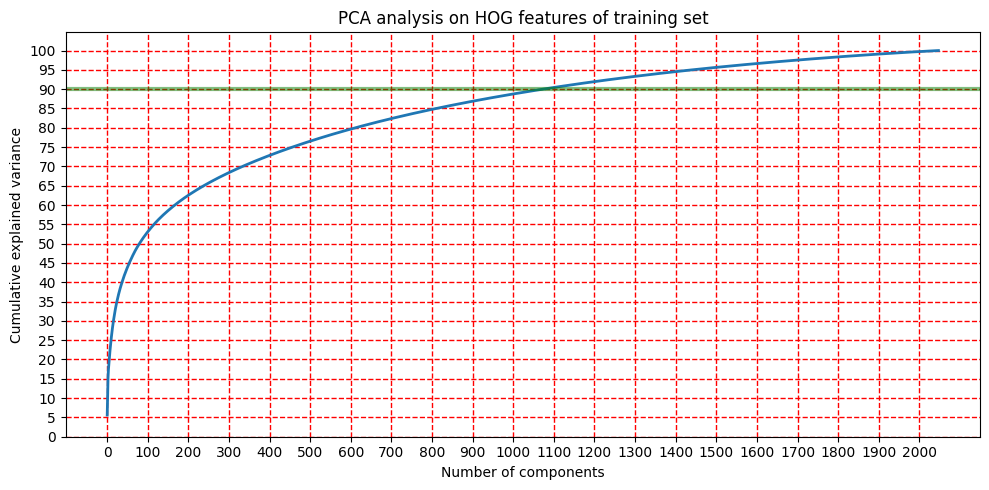

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

90.44478267508579

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

Original shape:    (44099, 2048)
Transformed shape: (44099, 1100)


In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0001-aggregates.png,0.939521,1.427068,0.160153,-1.101771,-1.505959,-0.946847,-0.010380,-0.755271,-0.122177,...,-0.415068,-1.721783,2.212496,0.585304,-0.668340,-0.454989,-0.472800,0.029105,-0.127471,-1.462955
1,0002-aggregates.png,-0.016433,0.085104,1.071777,-0.723463,-1.416125,-0.652845,-0.199367,0.927099,0.219271,...,-0.393005,1.128203,-0.024059,-0.014156,0.600116,1.231951,1.477751,3.245014,-0.577392,-0.087490
2,0004-aggregates.png,-1.308085,1.109958,-0.536983,-0.030714,-0.473369,-1.306480,0.731195,-1.021078,-1.230801,...,-0.527559,-0.946181,1.259875,-0.473580,1.897243,0.968025,0.632915,0.268045,-0.667532,0.351762
3,0004.png,0.782161,-0.214615,1.373268,1.606214,-1.281327,-0.096618,-0.749075,-1.523342,-1.385394,...,-0.003915,0.427827,0.134935,1.286162,1.171474,-0.411318,1.329629,-1.220084,0.423582,1.073487
4,0005-aggregates.png,0.219535,-0.742943,-0.718212,0.212367,0.797423,-0.884481,-0.987095,-0.539020,-0.166109,...,0.124577,0.669175,0.148373,2.152839,-0.525691,-1.744503,0.811050,-0.647016,-0.273736,-0.581508


(44099, 1101)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

Extract HOG:   0%|          | 0/14700 [00:00<?, ?it/s]

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

Original shape:    (14700, 2048)
Transformed shape: (14700, 1100)


In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0002.png,0.344972,-0.928782,0.804029,-0.479591,0.588745,1.549811,-0.000783,-1.551123,-0.597946,...,-0.327792,0.296356,2.348425,-1.628121,0.643192,0.401500,-0.934512,-0.143353,-1.330135,-0.826922
1,0003-aggregates.png,2.879473,1.522155,0.639572,1.457542,-0.921154,2.390067,-0.762593,2.038160,-1.320133,...,0.660299,0.814411,-0.260897,0.991871,0.912935,-2.164270,-1.210537,-1.498188,0.152277,1.376036
2,0008-aggregates.png,-0.640206,-1.348753,0.012081,0.694277,-0.467492,0.277465,1.431348,0.006000,0.473003,...,-0.308303,-0.145306,0.199854,0.933020,-1.268828,0.360317,-0.532387,-0.035153,-0.374522,0.471007
3,001-aggregates_003.png,0.955387,2.616215,0.798324,-0.600646,-1.396582,0.068432,-1.336661,-0.733416,1.022640,...,0.656353,0.334594,-0.089904,1.448092,0.970404,2.185549,0.123249,-2.641407,-0.134512,0.589413
4,001-aggregates_006.png,0.341750,-0.847429,-0.067560,-0.415468,1.302986,-0.199045,0.180813,-1.173031,-0.381453,...,0.838327,0.417953,-0.713181,-1.342573,-0.427658,-0.305121,-0.123370,0.124106,1.251320,-0.722199


(14700, 1101)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

Extract HOG:   0%|          | 0/6907 [00:00<?, ?it/s]

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

Original shape:    (6907, 2048)
Transformed shape: (6907, 1100)


In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_2.csv", header=False, index=False)

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,0007-aggregates_002.png,-0.084828,0.324666,1.042687,-1.079308,-0.481635,-0.935537,-0.155899,-0.310544,0.416677,...,-0.357494,-1.122227,0.079258,0.378196,-0.976928,-1.336399,0.002920,-1.346101,-0.485684,-0.687447
1,0009-aggregates_001.png,1.076887,-1.309871,-0.728400,0.500154,1.074758,-2.587898,0.409962,0.315233,-1.211380,...,0.846101,-0.873514,-1.152154,-0.900361,1.178646,2.226271,0.205222,0.391807,1.355143,-1.178915
2,0012-aggregates_002.png,-0.255591,-0.889571,0.861222,0.405446,-0.221765,0.628911,-0.856405,-0.382488,-0.706104,...,0.374484,-0.722594,0.320618,0.226189,-0.664762,0.174853,1.289655,-0.892794,-1.037260,0.951886
3,002-aggregates_001.png,0.772760,0.978373,-1.204573,-0.973090,-0.148900,1.238766,0.371844,0.153808,0.602470,...,-0.138676,1.078928,1.373407,-1.498287,0.856990,-1.426160,1.030719,-0.098940,0.844066,0.673098
4,002-aggregates_007.png,1.636996,-0.068754,1.050464,0.347307,1.580382,1.571963,1.923754,-1.101774,-2.523573,...,1.465811,-0.777160,1.746052,-1.557608,-0.730564,-1.205231,1.563719,0.291714,-0.097705,1.287043


(6907, 1101)